In [1]:
import os
import sys

# add parent folder to path if needed
parent_dir = os.getcwd().replace('\\notebooks', '')
if parent_dir not in sys.path:
    sys.path = [parent_dir] + sys.path

import random
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

from src import regressions as reg
from src.models import MLP, SBR, SBRBatchGenerator, UnivariateSBR, hard_tanh

random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)
sns.set_style('whitegrid')
sns.set_context('notebook')
reg.import_extension_methods()

output_act = None
h_units = [16] * 4

# Synthetic Dataset

150 (train samples), 50 (validation samples), 500 (test samples)


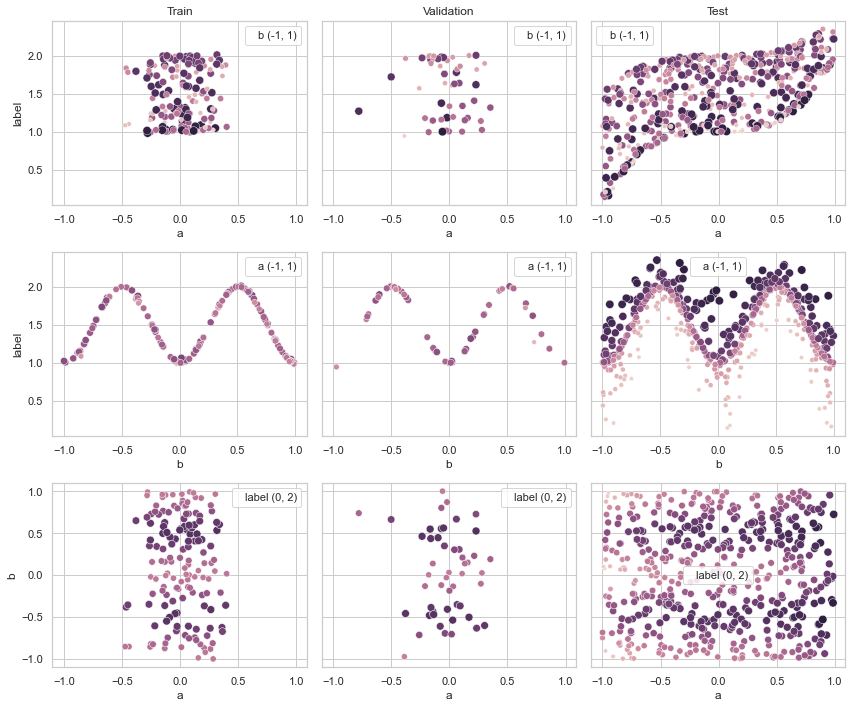

In [2]:
data = reg.load_synthetic()
x_train, y_train = data['train']
x_val, y_val = data['validation']

reg.plot_synthetic(**data)

## MLP

0.9889 (train r2), 0.9921 (validation r2), 0.763 (test r2)


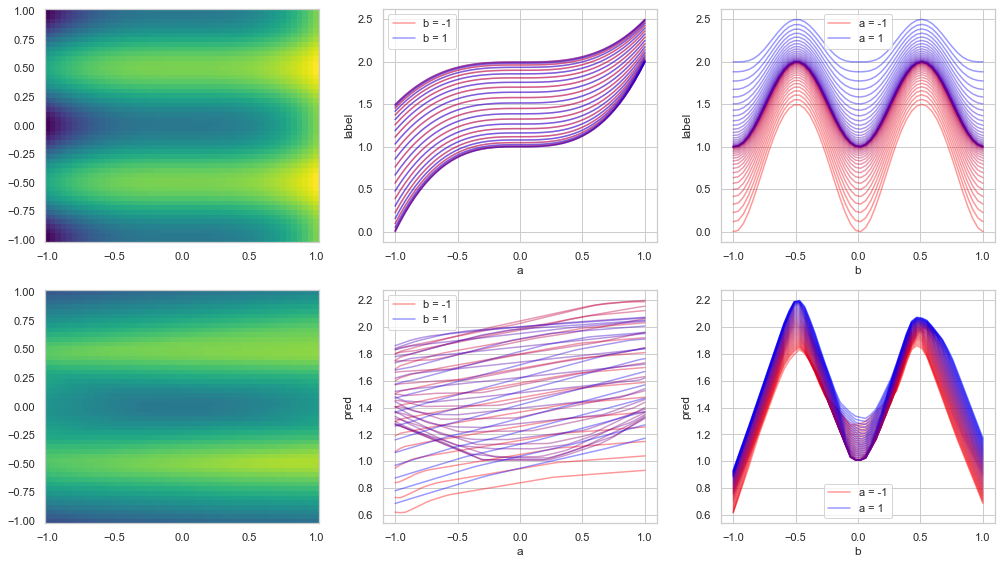

In [3]:
mlp = MLP(output_act=output_act, h_units=h_units)
mlp.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
mlp.fit(x_train, y_train, epochs=1000, validation_data=(x_val, y_val), callbacks=[early_stopping], verbose=0)
mlp.synthetic_summary(**data)

## SBR

In [4]:
x_aug, y_aug, _ = reg.get_augmented_data(x_train, y_train, directions=[1, 0], num_augmented_samples=15)
sbr_batches = SBRBatchGenerator(x_aug, y_aug['label'], y_aug['ground_index'], y_aug['monotonicity'], 4)
sbr_batches.batches[0].head(16)

,a,b,label,monotonicity
0,0.512573,0.652615,0.63922,0.0
1,0.548814,0.652615,NaN,1.0
2,0.715189,0.652615,NaN,1.0
3,0.602763,0.652615,NaN,1.0
4,0.544883,0.652615,NaN,1.0
5,0.423655,0.652615,NaN,-1.0
6,0.645894,0.652615,NaN,1.0
7,0.437587,0.652615,NaN,-1.0
8,0.891773,0.652615,NaN,1.0
9,0.963663,0.652615,NaN,1.0


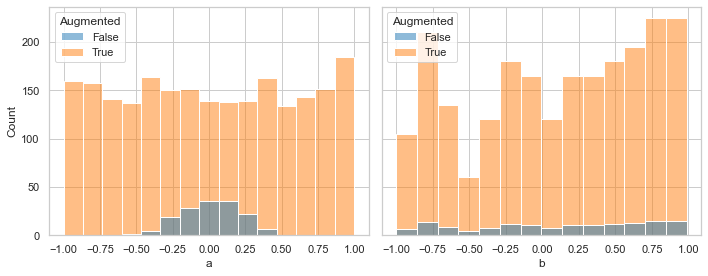

In [5]:
reg.plot_synthetic_augmented(x_aug, y_aug['label'], x_scaler=data['scalers'][0])

0.9974 (train r2), 0.9959 (validation r2), 0.7863 (test r2)


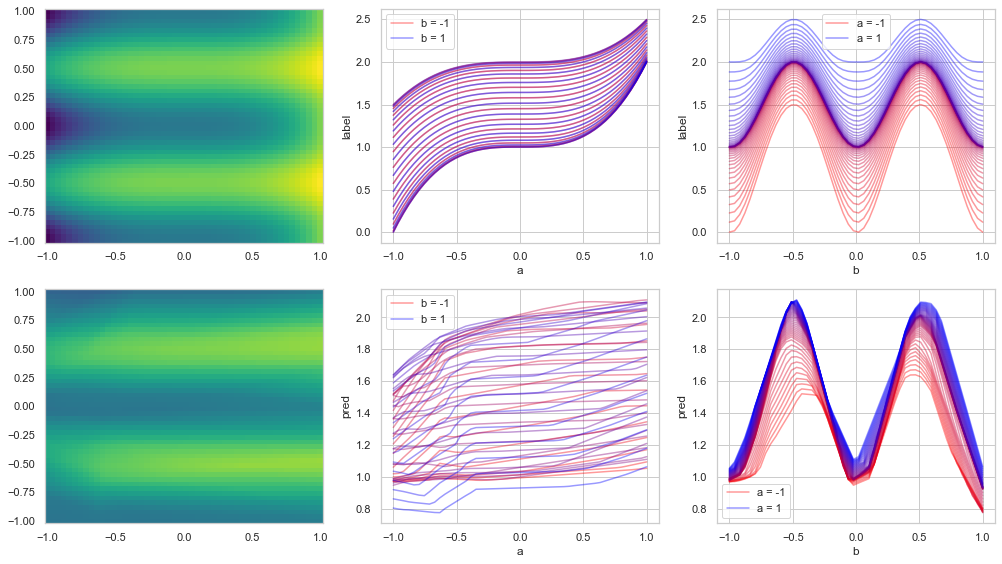

In [6]:
sbr_none = SBR(output_act=output_act, h_units=h_units)
sbr_none.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
sbr_none.fit(sbr_batches, epochs=1000, validation_data=(x_val, y_val), callbacks=[early_stopping], verbose=0)
sbr_none.synthetic_summary(**data)

## SBR Tanh

0.9823 (train r2), 0.9823 (validation r2), 0.8059 (test r2)


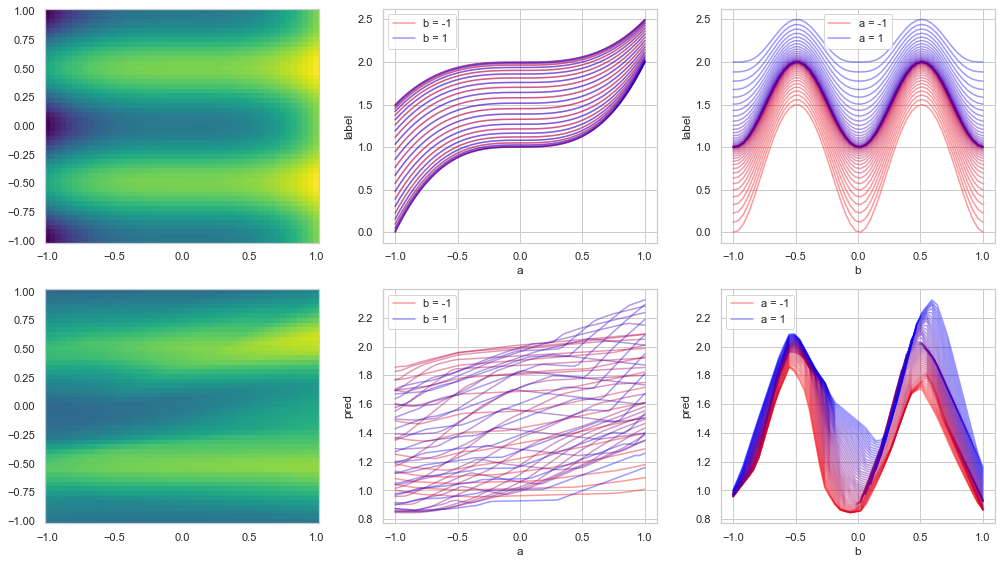

In [7]:
sbr_tanh = SBR(output_act=output_act, h_units=h_units, regularizer_act=hard_tanh)
sbr_tanh.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
sbr_tanh.fit(sbr_batches, epochs=1000, validation_data=(x_val, y_val), callbacks=[early_stopping], verbose=0)
sbr_tanh.synthetic_summary(**data)

# Cars Dataset

99 train samples, 25 validation samples, 31 test samples


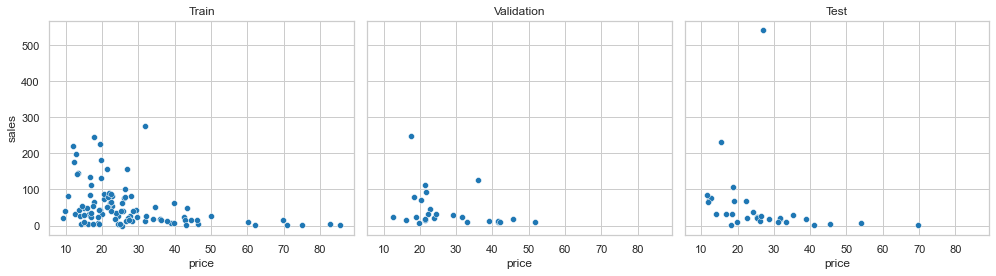

In [8]:
data = reg.load_cars('../res/cars.csv')
x_train, y_train = data['train']
x_val, y_val = data['validation']

reg.plot_cars(**data)

## MLP

0.1244 (train r2), 0.1019 (validation r2), 0.04617 (test r2)


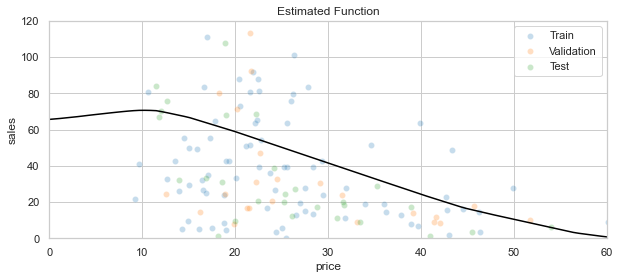

In [9]:
mlp = MLP(output_act=output_act, h_units=h_units)
mlp.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
mlp.fit(x_train, y_train, epochs=1000, validation_data=(x_val, y_val), callbacks=[early_stopping], verbose=0)
mlp.cars_summary(**data)

## SBR Without Augmentation

0.1224 (train r2), 0.1032 (validation r2), 0.04412 (test r2)


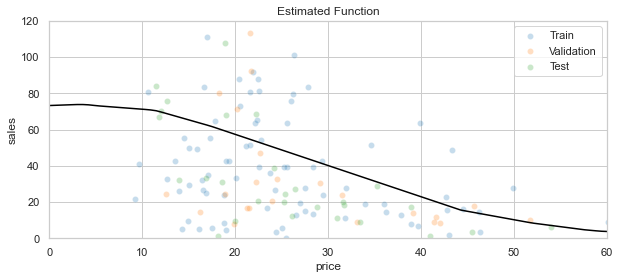

In [10]:
sbr_uni = UnivariateSBR(direction=-1, output_act=output_act, h_units=h_units, input_dim=1)
sbr_uni.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
sbr_uni.fit(x_train, y_train, epochs=1000, validation_data=(x_val, y_val), callbacks=[early_stopping], verbose=0)
sbr_uni.cars_summary(**data)

## SBR With Augmentation

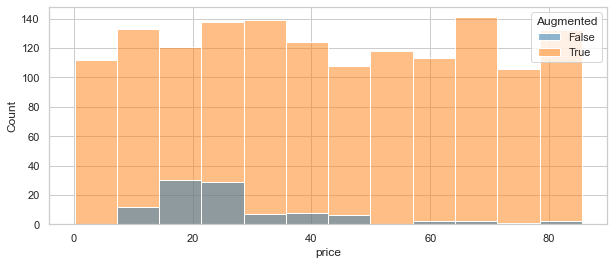

In [11]:
x_aug, y_aug, _ = reg.get_augmented_data(x_train, y_train, directions=-1, num_augmented_samples=15)
reg.plot_cars_augmented(x_aug, y_aug['sales'], x_scaler=data['scalers'][0])

0.1216 (train r2), 0.1062 (validation r2), 0.04358 (test r2)


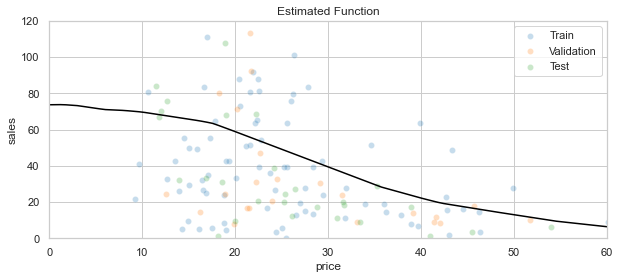

In [12]:
sbr_aug = UnivariateSBR(direction=-1, output_act=output_act, h_units=h_units, input_dim=1)
sbr_aug.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
sbr_aug.fit(x_aug, y_aug['sales'], validation_data=(x_val, y_val), epochs=1000, callbacks=[early_stopping], verbose=0)
sbr_aug.cars_summary(**data)

# Puzzles Dataset

In [13]:
data = reg.load_puzzles('../res/puzzles.csv')
x_train, y_train = data['train']
x_val, y_val = data['validation']
x_train.join(y_train)

,word_count,star_rating,num_reviews,label
0,0.160909,0.800000,0.072727,0.046105
1,0.520699,0.969231,0.236364,0.085851
2,0.182246,0.964706,0.309091,0.297297
3,0.401818,0.933333,0.272727,0.287758
4,0.032727,1.000000,0.018182,0.071542
...,...,...,...,...
150,0.271091,1.000000,0.181818,0.117647
151,0.130909,0.977778,0.163636,0.076312
152,0.252587,1.000000,0.236364,0.049285
153,0.180000,0.920000,0.090909,0.038156


155 train samples, 168 validation samples, 199 test samples


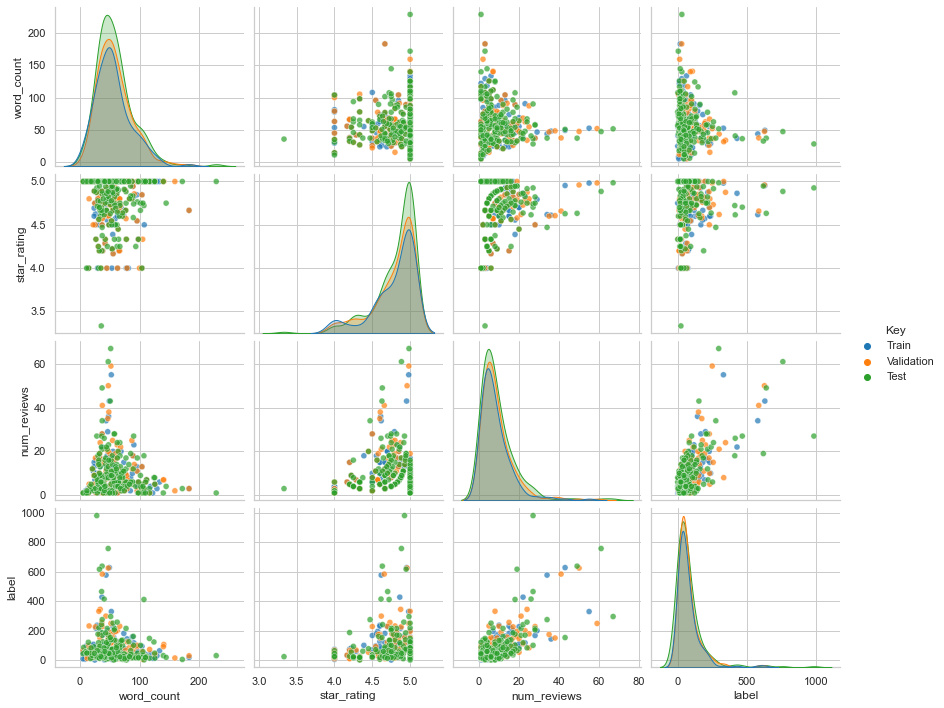

In [14]:
reg.plot.plot_puzzles(**data)

## MLP

0.6053 (train r2), 0.5394 (validation r2), 0.4816 (test r2)


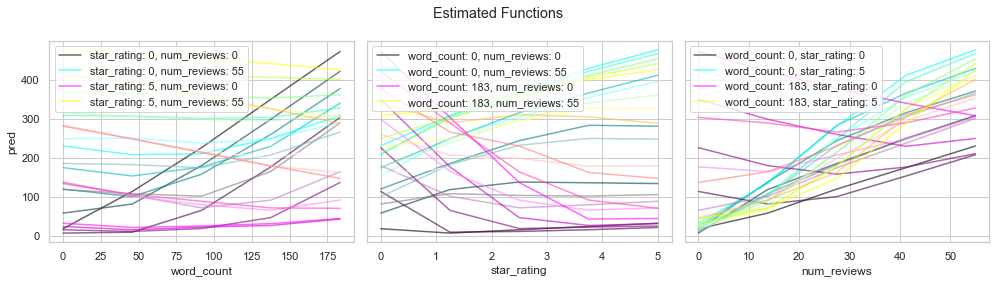

In [15]:
mlp = MLP(output_act=output_act, h_units=h_units)
mlp.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
mlp.fit(x_train, y_train, epochs=1000, validation_data=(x_val, y_val), callbacks=[early_stopping], verbose=0)
mlp.puzzles_summary(**data)

## SBR

* word_count: decreasing (longer reviews are less effective)
* star_rating: increasing (higher ratings lead to higher sales)
* num_reviews: increasing (higher number of reviews are more effective)

Some randomly generated samples are added to the initial dataset to cover a larger portion of the sampling space, otherwise the attribute `num_reviews` is forced to be monotonic just for the portion of the space covered by the ground samples with respect to the other to attributes. Moreover, more samples are generated for this specific attribute being both the most important and the most difficult to constraint.

In [16]:
x_aug, y_aug, _ = reg.get_augmented_data(
    x=x_train, y=y_train,
    directions={'word_count': -1, 'star_rating': 1, 'num_reviews': 1},
    num_random_samples=3 * len(x_train),
    num_augmented_samples={'word_count': 3, 'star_rating': 4, 'num_reviews': 8}
)
sbr_batches = SBRBatchGenerator(x_aug, y_aug['label'], y_aug['ground_index'], y_aug['monotonicity'], 4)
sbr_batches.batches[0].head(16)

,word_count,star_rating,num_reviews,label,monotonicity
0,0.434026,1.000000,0.127273,0.081081,0.0
1,0.714880,1.000000,0.127273,NaN,-1.0
2,0.597946,1.000000,0.127273,NaN,-1.0
3,0.707956,1.000000,0.127273,NaN,-1.0
4,0.434026,0.002726,0.127273,NaN,-1.0
5,0.434026,0.145521,0.127273,NaN,-1.0
6,0.434026,0.691750,0.127273,NaN,-1.0
7,0.434026,0.714969,0.127273,NaN,-1.0
8,0.434026,1.000000,0.852973,NaN,1.0
9,0.434026,1.000000,0.585550,NaN,1.0


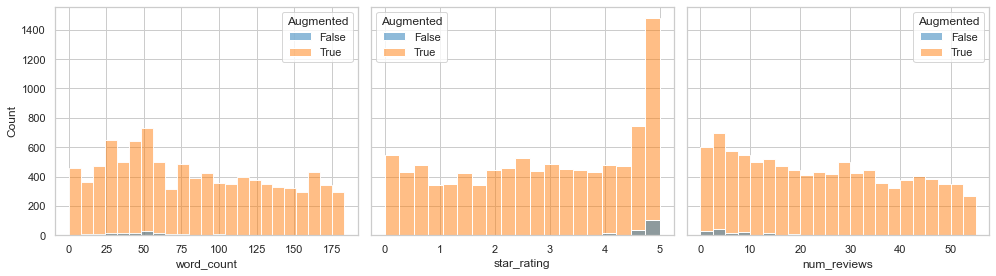

In [17]:
reg.plot_puzzles_augmented(x_aug, y_aug['label'], x_scaler=data['scalers'][0])

0.6437 (train r2), 0.6013 (validation r2), 0.5447 (test r2)


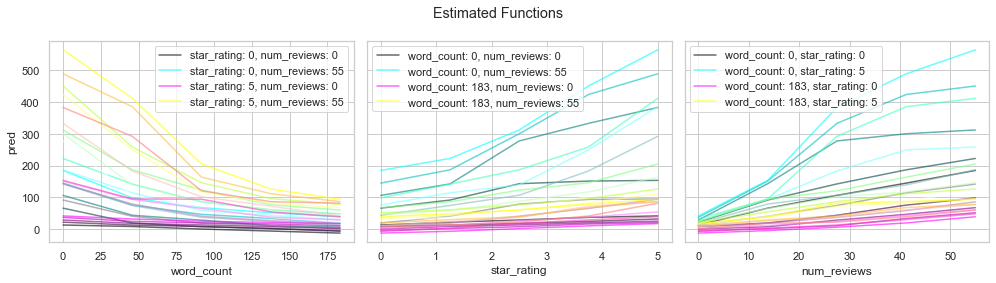

In [18]:
sbr_none = SBR(output_act=output_act, h_units=h_units, alpha=None)
sbr_none.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
sbr_none.fit(sbr_batches, epochs=1000, validation_data=(x_val, y_val), callbacks=[early_stopping], verbose=0)
sbr_none.puzzles_summary(**data)

## SBR Tanh

0.6217 (train r2), 0.5635 (validation r2), 0.5102 (test r2)


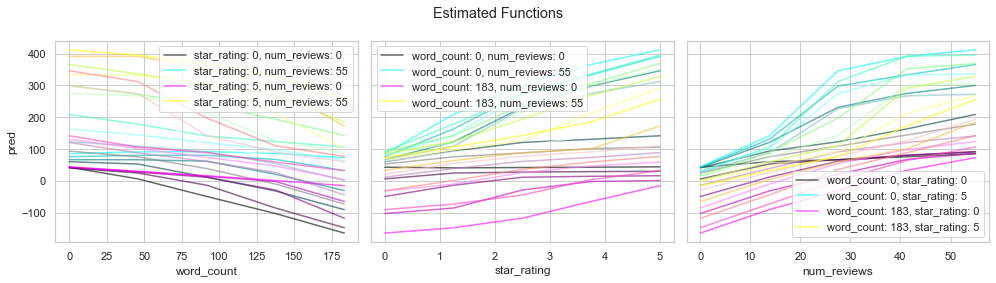

In [19]:
sbr_tanh = SBR(output_act=output_act, h_units=h_units, regularizer_act=hard_tanh)
sbr_tanh.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
sbr_tanh.fit(sbr_batches, epochs=1000, validation_data=(x_val, y_val), callbacks=[early_stopping], verbose=0)
sbr_tanh.puzzles_summary(**data)